In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}

background_classes = {'cat', 'deer', 'dog', 'frog', 'horse','ship', 'truck'}

fg1,fg2,fg3 = 0,1,2

In [7]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

In [8]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]- fg1  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [9]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)

In [10]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 125
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [75]:
class Focus(nn.Module):
  def __init__(self):
    super(Focus, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 64)
    self.fc3 = nn.Linear(64, 10)
    self.fc4 = nn.Linear(10,2)

  def forward(self,z):  #y is avg image #z batch of list of 9 images
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = y.to("cuda")
    x = x.to("cuda")
    
    for i in range(9):
        x[:,i] = self.helper(z[:,i])[:,0]

    x = F.softmax(x,dim=1)

    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])

    return x, y
    
  def helper(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    # print(x.shape)
    x = (F.relu(self.conv3(x)))
    x =  x.view(x.size(0), -1)
    # print(x.shape)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [76]:
focus_net13 = Focus().double()
focus_net13 = focus_net13.to("cuda")

In [77]:
focus_net13.load_state_dict( torch.load("/content/drive/My Drive/Research/Cheating_data/Focus_net_weights/focus_net_3layer_cnn.pt"))

<All keys matched successfully>

In [78]:
focus_net13.fc4

Linear(in_features=10, out_features=2, bias=True)

In [79]:
print(focus_net13.fc4)
print(focus_net13.fc4.weight)
print(focus_net13.fc4.bias)
temp = focus_net13.fc4.weight.data
temp2 = focus_net13.fc4.bias.data
focus_net13.fc4 = nn.Linear(10,1).double()
focus_net13.fc4.weight.data = torch.unsqueeze(temp[1,:], 0)
focus_net13.fc4.bias.data = torch.unsqueeze(temp2[1], 0)
focus_net13 = focus_net13.to("cuda")
print(focus_net13.fc4.weight)
print(focus_net13.fc4.bias)

Linear(in_features=10, out_features=2, bias=True)
Parameter containing:
tensor([[-0.3198, -0.1404,  1.5384,  0.7315, -0.1772,  0.1583, -0.2523, -0.2352,
         -1.7105, -0.1908],
        [ 0.3026,  0.1300, -1.6173, -0.8441,  0.0563,  0.0410,  0.1276, -0.0125,
          1.3969, -0.2657]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
Parameter containing:
tensor([-0.1808,  0.1159], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
Parameter containing:
tensor([[ 0.3026,  0.1300, -1.6173, -0.8441,  0.0563,  0.0410,  0.1276, -0.0125,
          1.3969, -0.2657]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
Parameter containing:
tensor([0.1159], device='cuda:0', dtype=torch.float64, requires_grad=True)


In [80]:
focus_net13.fc4

Linear(in_features=10, out_features=1, bias=True)

In [81]:
focus_net9 = Focus().double()
focus_net9 = focus_net9.to("cuda")

In [82]:
# print(focus_net9)
focus_net9.fc4 = nn.Linear(10,1).double()
focus_net9 = focus_net9.to("cuda")
focus_net9

Focus(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)

In [83]:
beta = np.arange(0,1.01,0.01)

In [84]:
beta

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [85]:
modelA = nn.Linear(1, 1)
modelB = nn.Linear(1, 1)

sdA = modelA.state_dict()
sdB = modelB.state_dict()

# Average all parameters
for key in sdA:
    sdB[key] = (sdB[key] + sdA[key]) / 2.

# Recreate model and load averaged state_dict (or use modelA/B)
model = nn.Linear(1, 1)
model.load_state_dict(sdB)

<All keys matched successfully>

In [109]:
def create_model(b , f9, f13):
  sd9 = f9.state_dict()
  sd13 = f13.state_dict()

  for key in sd9:
    sd13[key] = (1-b)*sd9[key] + (b)*sd13[key] 

  focus_net = Focus().double()
  focus_net.fc4 = nn.Linear(10,1).double()
  focus_net = focus_net.to("cuda")

  focus_net.load_state_dict(sd13)

  return focus_net
  

In [110]:
list_focus_net = []
for i in range(len(beta)):
  model = create_model(beta[i], focus_net9, focus_net13)
  list_focus_net.append(model)

In [111]:
len(list_focus_net)

101

In [112]:
list_focus_net[0].state_dict()

OrderedDict([('conv1.weight', tensor([[[[ 0.1471, -0.1440,  0.0779],
                        [ 0.1247,  0.0980, -0.1119],
                        [-0.1246, -0.0817, -0.1593]],
              
                       [[ 0.0171,  0.1040,  0.1573],
                        [ 0.1600, -0.0600,  0.0849],
                        [ 0.0805, -0.0977,  0.0176]],
              
                       [[ 0.0296,  0.1475, -0.0405],
                        [-0.1240,  0.1736, -0.1821],
                        [-0.0807,  0.1303, -0.1005]]],
              
              
                      [[[-0.0606,  0.0788,  0.1341],
                        [-0.1754, -0.1312,  0.0353],
                        [ 0.1852,  0.1567, -0.1883]],
              
                       [[-0.0818, -0.0581, -0.1041],
                        [ 0.1001, -0.1663,  0.0872],
                        [ 0.0730, -0.0855, -0.1653]],
              
                       [[ 0.1030, -0.0492, -0.1182],
                        [-0.1030, -0.159

In [115]:
focus_net9.state_dict()

OrderedDict([('conv1.weight', tensor([[[[ 0.1471, -0.1440,  0.0779],
                        [ 0.1247,  0.0980, -0.1119],
                        [-0.1246, -0.0817, -0.1593]],
              
                       [[ 0.0171,  0.1040,  0.1573],
                        [ 0.1600, -0.0600,  0.0849],
                        [ 0.0805, -0.0977,  0.0176]],
              
                       [[ 0.0296,  0.1475, -0.0405],
                        [-0.1240,  0.1736, -0.1821],
                        [-0.0807,  0.1303, -0.1005]]],
              
              
                      [[[-0.0606,  0.0788,  0.1341],
                        [-0.1754, -0.1312,  0.0353],
                        [ 0.1852,  0.1567, -0.1883]],
              
                       [[-0.0818, -0.0581, -0.1041],
                        [ 0.1001, -0.1663,  0.0872],
                        [ 0.0730, -0.0855, -0.1653]],
              
                       [[ 0.1030, -0.0492, -0.1182],
                        [-0.1030, -0.159

In [114]:
list_focus_net[100].state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 5.1012e-01,  5.5293e-01,  2.1752e-01],
                        [-9.3242e-02,  2.1292e-01, -1.0541e-01],
                        [-4.2901e-01, -5.1375e-01, -1.7828e-01]],
              
                       [[ 2.6402e-01,  2.2047e-01,  1.7062e-01],
                        [-6.1617e-02, -2.3764e-02, -9.2725e-02],
                        [-1.3579e-01, -4.7987e-01, -1.8543e-01]],
              
                       [[-7.1597e-02,  2.8060e-01, -4.8433e-02],
                        [ 1.4421e-01,  2.5523e-01, -2.7313e-01],
                        [-2.4865e-01, -1.5819e-02,  2.2224e-01]]],
              
              
                      [[[-5.4389e-02, -3.1724e-01, -4.8299e-02],
                        [ 2.8088e-01,  3.8326e-02, -1.2630e-01],
                        [-2.6675e-01,  1.1095e-01, -2.6749e-02]],
              
                       [[ 9.7539e-02, -1.6986e-01,  2.3720e-01],
                        [-3.0981e-02,  1.9501

In [116]:
focus_net13.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 5.1012e-01,  5.5293e-01,  2.1752e-01],
                        [-9.3242e-02,  2.1292e-01, -1.0541e-01],
                        [-4.2901e-01, -5.1375e-01, -1.7828e-01]],
              
                       [[ 2.6402e-01,  2.2047e-01,  1.7062e-01],
                        [-6.1617e-02, -2.3764e-02, -9.2725e-02],
                        [-1.3579e-01, -4.7987e-01, -1.8543e-01]],
              
                       [[-7.1597e-02,  2.8060e-01, -4.8433e-02],
                        [ 1.4421e-01,  2.5523e-01, -2.7313e-01],
                        [-2.4865e-01, -1.5819e-02,  2.2224e-01]]],
              
              
                      [[[-5.4389e-02, -3.1724e-01, -4.8299e-02],
                        [ 2.8088e-01,  3.8326e-02, -1.2630e-01],
                        [-2.6675e-01,  1.1095e-01, -2.6749e-02]],
              
                       [[ 9.7539e-02, -1.6986e-01,  2.3720e-01],
                        [-3.0981e-02,  1.9501

In [117]:
# for params in focus_net.parameters():
#   params.requires_grad = False

In [118]:
# for params in focus_net.parameters():
#   print(params.requires_grad)

In [119]:
# for params in focus_net.parameters():
#   print(params)
#   break;

In [120]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 64)
    self.fc3 = nn.Linear(64, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    # print(x.shape)
    x = (F.relu(self.conv3(x)))
    x =  x.view(x.size(0), -1)
    # print(x.shape)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [121]:
classify = Classification().double()
classify = classify.to("cuda")

In [122]:
classify.load_state_dict( torch.load("/content/drive/My Drive/Research/Cheating_data/Classify_net_weights/classify_net_3layer_cnn.pt"))

<All keys matched successfully>

In [99]:
# for params in classify.parameters():
#   print(params.requires_grad)
#   break
  

In [100]:
# for params in classify.parameters():
#   print(params)
#   break;

In [123]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [124]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [125]:
def without_train_ret_data(loader, focus_net, classify):
  correct = 0
  total = 0
  count = 0
  flag = 1
  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0

  argmax_more_than_half = 0
  argmax_less_than_half =0

  with torch.no_grad():
    for data in loader:
      inputs, labels , fore_idx = data
      inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
      alphas, avg_images = focus_net(inputs)
      outputs = classify(avg_images)

      _, predicted = torch.max(outputs.data, 1)

      for j in range(labels.size(0)):
        focus = torch.argmax(alphas[j])
        if alphas[j][focus] >= 0.5 :
          argmax_more_than_half += 1
        else:
          argmax_less_than_half += 1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1
        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true += 1
        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false += 1
        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false += 1

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  # print('Accuracy of the network on the 30000 train images: %d %%' % (
  #     100 * correct / total))
  # print("total correct", correct)
  # print("total train set images", total)

  # print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
  # print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
  # print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
  # print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

  # print("argmax_more_than_half ==================> ",argmax_more_than_half)
  # print("argmax_less_than_half ==================> ",argmax_less_than_half)

  return argmax_more_than_half, argmax_less_than_half, (100*correct/total), correct, total, (100*focus_true_pred_true / total), (100*focus_false_pred_true/total), (100*focus_true_pred_false/total), (100*focus_false_pred_false/total)

In [130]:
tr_more=[]
tr_less=[]
tr_acc = []
tr_cor = []
tr_tot = []
tr_ftpt = []
tr_ffpt = []
tr_ftpf = []
tr_ffpf = []
for i in range(len(list_focus_net)):
  more, less, acc, cor, tot, ftpt, ffpt, ftpf, ffpf = without_train_ret_data(train_loader, list_focus_net[i], classify)
  tr_more.append(more)
  tr_less.append(less)
  tr_acc.append(acc)
  tr_cor.append(cor)
  tr_tot.append(tot)
  tr_ftpt.append(ftpt)
  tr_ffpt.append(ffpt)
  tr_ftpf.append(ftpf)
  tr_ffpf.append(ffpf)
  print(" finished executing ", i, round(acc,1), cor, tot, round(ftpt,1), round(ffpt,1), round(ftpf,1), round(ffpf,1))

 finished executing  0 33.4 10019 30000 2.9 30.5 8.3 58.3
 finished executing  1 33.4 10019 30000 2.9 30.5 8.6 58.0
 finished executing  2 33.4 10019 30000 3.0 30.4 8.8 57.8
 finished executing  3 33.4 10019 30000 2.9 30.5 8.9 57.7
 finished executing  4 33.4 10019 30000 2.8 30.6 8.9 57.7
 finished executing  5 33.4 10019 30000 2.8 30.6 9.0 57.6
 finished executing  6 33.4 10019 30000 2.8 30.6 9.2 57.4
 finished executing  7 33.4 10019 30000 2.8 30.6 9.5 57.1
 finished executing  8 33.4 10019 30000 2.8 30.6 10.0 56.6
 finished executing  9 33.4 10019 30000 2.6 30.8 10.7 55.9
 finished executing  10 33.4 10019 30000 2.5 30.9 11.4 55.2
 finished executing  11 33.4 10019 30000 2.5 30.9 12.5 54.1
 finished executing  12 33.4 10018 30000 2.5 30.9 13.3 53.3
 finished executing  13 33.4 10018 30000 2.6 30.8 14.0 52.6
 finished executing  14 33.4 10018 30000 2.7 30.7 14.6 52.0
 finished executing  15 33.4 10018 30000 2.9 30.5 15.1 51.5
 finished executing  16 33.4 10018 30000 3.1 30.3 15.4 51.

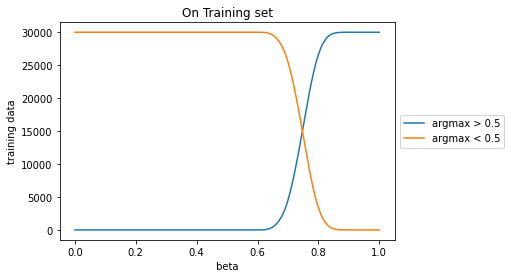

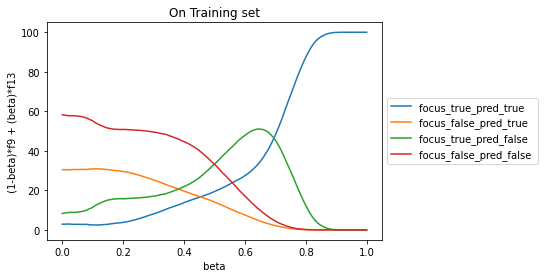

In [131]:
plt.plot(beta, tr_more, label='argmax > 0.5')
plt.plot(beta, tr_less, label='argmax < 0.5')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(" beta ")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(beta,tr_ftpt, label ="focus_true_pred_true ")
plt.plot(beta,tr_ffpt, label ="focus_false_pred_true ")
plt.plot(beta,tr_ftpf, label ="focus_true_pred_false ")
plt.plot(beta,tr_ffpf, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(" beta ")
plt.ylabel(" (1-beta)*f9 + (beta)*f13 ")
plt.show()

In [132]:
te_more=[]
te_less=[]
te_acc = []
te_cor = []
te_tot = []
te_ftpt = []
te_ffpt = []
te_ftpf = []
te_ffpf = []
for i in range(len(list_focus_net)):
  more, less, acc, cor, tot, ftpt, ffpt, ftpf, ffpf = without_train_ret_data(test_loader, list_focus_net[i], classify)
  te_more.append(more)
  te_less.append(less)
  te_acc.append(acc)
  te_cor.append(cor)
  te_tot.append(tot)
  te_ftpt.append(ftpt)
  te_ffpt.append(ffpt)
  te_ftpf.append(ftpf)
  te_ffpf.append(ffpf)
  print(" finished executing ", i, round(acc,1), cor, tot, round(ftpt,1), round(ffpt,1), round(ftpf,1), round(ffpf,1))

 finished executing  0 34.3 3433 10000 3.0 31.3 8.2 57.5
 finished executing  1 34.3 3433 10000 3.0 31.4 8.6 57.1
 finished executing  2 34.3 3433 10000 2.9 31.4 9.0 56.7
 finished executing  3 34.3 3433 10000 2.9 31.4 9.0 56.6
 finished executing  4 34.3 3433 10000 2.8 31.5 8.9 56.8
 finished executing  5 34.3 3433 10000 2.6 31.7 8.9 56.8
 finished executing  6 34.3 3433 10000 2.6 31.7 9.0 56.6
 finished executing  7 34.3 3433 10000 2.5 31.8 9.5 56.2
 finished executing  8 34.3 3433 10000 2.6 31.7 9.9 55.7
 finished executing  9 34.3 3433 10000 2.6 31.8 10.7 55.0
 finished executing  10 34.3 3433 10000 2.5 31.8 11.5 54.2
 finished executing  11 34.3 3433 10000 2.5 31.8 12.4 53.2
 finished executing  12 34.3 3433 10000 2.5 31.8 13.1 52.5
 finished executing  13 34.3 3433 10000 2.6 31.7 13.9 51.7
 finished executing  14 34.3 3433 10000 3.0 31.4 14.6 51.1
 finished executing  15 34.3 3433 10000 3.1 31.2 14.8 50.9
 finished executing  16 34.3 3433 10000 3.0 31.3 15.2 50.5
 finished execut

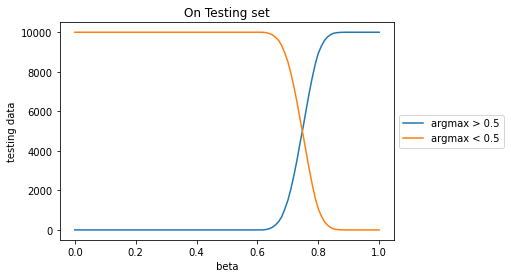

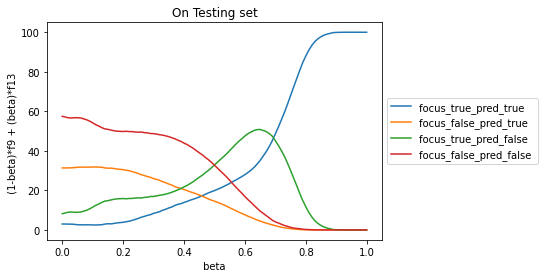

In [133]:
plt.plot(beta, te_more, label='argmax > 0.5')
plt.plot(beta, te_less, label='argmax < 0.5')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(" beta ")
plt.ylabel("testing data")
plt.title("On Testing set")
plt.show()

plt.plot(beta,te_ftpt, label ="focus_true_pred_true ")
plt.plot(beta,te_ffpt, label ="focus_false_pred_true ")
plt.plot(beta,te_ftpf, label ="focus_true_pred_false ")
plt.plot(beta,te_ffpf, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(" beta ")
plt.ylabel(" (1-beta)*f9 + (beta)*f13  ")
plt.show()

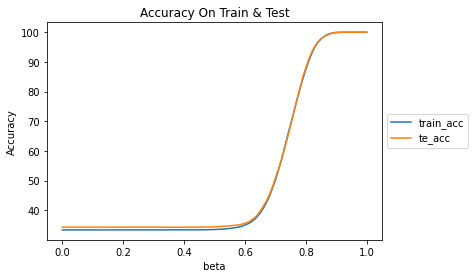

In [134]:
plt.plot(beta, tr_acc, label='train_acc')
plt.plot(beta, te_acc, label='te_acc')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(" beta ")
plt.ylabel("Accuracy")
plt.title("Accuracy On Train & Test")
plt.show()